In [ ]:
%pwd

'/content'

In [ ]:
from google.colab import drive
drive.mount('../content/drive', force_remount=True)

Mounted at ../content/drive


# 바꿔야할 부분
※ 경로

In [ ]:
cd ../content/drive/My Drive/졸업작품/30words_classification

/content/drive/My Drive/졸업작품/30words_classification


In [ ]:
''' import libraries '''

%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms  # 1 batch = (1, 784)
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
import numpy as np
from torchsummary import summary

In [ ]:
# torch.device
print("is there cuda? :",  torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

is there cuda? : True
cuda:0


In [ ]:
## data load
X_train, X_test, Y_train, Y_test = np.load("./data.npy", allow_pickle=True)

## CV data split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_valid, X_test, Y_valid, Y_test = train_test_split(np.array(X_test), np.array(Y_test), test_size=0.3, shuffle=True)
print(Y_valid.shape)

(2100, 30)


In [ ]:
## data rehspae and normalize

Y_train = np.array([Y_train]) # (1, 27000, 30)
Y_train = np.transpose(Y_train, (1, 0, 2))  # (27000, 1, 30)
Y_valid = np.array([Y_valid]) # (1, 2100, 30)
Y_valid = np.transpose(Y_valid, (1, 0, 2))  # (2100, 1, 30)
Y_test = np.array([Y_test]) # (1, 900, 30)
Y_test = np.transpose(Y_test, (1, 0, 2))  # (900, 1, 30)

X_train = transforms.Normalize(mean=(0.0,), std=(1.0,))(torch.Tensor(X_train))
Y_train = transforms.Normalize(mean=(0.0,), std=(1.0,))(torch.Tensor(Y_train))

X_valid = transforms.Normalize(mean=(0.0,), std=(1.0,))(torch.Tensor(X_valid))
Y_valid = transforms.Normalize(mean=(0.0,), std=(1.0,))(torch.Tensor(Y_valid))

X_test = transforms.Normalize(mean=(0.0,), std=(1.0,))(torch.Tensor(X_test))
Y_test = transforms.Normalize(mean=(0.0,), std=(1.0,))(torch.Tensor(Y_test))

print("X_train.shape", X_train.shape)  # (27000, 173, 24)
print("Y_train.shape", Y_train.shape)  # (27000, 1, 30)
print("X_valid.shape", X_valid.shape)  # (2100, 173, 24)
print("Y_valid.shape", Y_valid.shape)  # (1, 2100, 30)
print("X_test.shape", X_test.shape)  # (900, 173, 24)
print("Y_test.shape", Y_test.shape)  # (1, 900, 30)
# print("X_train[0]", X_train[0])  # 이미 되어있네? mean=0, std=1 로 되어있네


ValueError: ignored

In [ ]:
print(Y_train[0])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])


In [ ]:
n_mfcc = 24
Tx = 173
num_class = 30

In [ ]:
## resnet 구현

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)


# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_class, p2=0.0): # 10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16) # conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(4)  # 8
        self.fc = nn.Linear(64*11, num_classes)

        self.dropout2d = nn.Dropout2d(p=p2)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.dropout2d(out)
        out = self.layer2(out)
        out = self.dropout2d(out)
        out = self.layer3(out)
        #out = self.dropout2d(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return nn.LogSoftmax(dim=-1)(out)

In [ ]:
''' hyper parameters '''
# total_batch_num = int(len(train_data) / batch_size)
epochs = 25
lr = 0.001
# momentum = 0.9
print_interval = 100
#drop_prob1 = 0.1 # ->fc에서는 덜 줄이고
drop_prob2 = 0.2  # ->conv에서 
weight_decay = 1e-3

# # model, optimizer 초기화
model = ResNet(ResidualBlock, [2, 2, 2], p2=drop_prob2).to(device)  # [2, 2, 2] : blocks at each layer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
summary(model,input_size=(1, Tx, n_mfcc))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 173, 24]             144
       BatchNorm2d-2          [-1, 16, 173, 24]              32
              ReLU-3          [-1, 16, 173, 24]               0
            Conv2d-4          [-1, 16, 173, 24]           2,304
       BatchNorm2d-5          [-1, 16, 173, 24]              32
              ReLU-6          [-1, 16, 173, 24]               0
            Conv2d-7          [-1, 16, 173, 24]           2,304
       BatchNorm2d-8          [-1, 16, 173, 24]              32
              ReLU-9          [-1, 16, 173, 24]               0
    ResidualBlock-10          [-1, 16, 173, 24]               0
           Conv2d-11          [-1, 16, 173, 24]           2,304
      BatchNorm2d-12          [-1, 16, 173, 24]              32
             ReLU-13          [-1, 16, 173, 24]               0
           Conv2d-14          [-1, 16, 

# 왜지?  
MNIST 코드에서,   
target.size = [batch_size]   
output.size = [batch_size, num_class]

F.nll_loss(output, target) -> 이 함수 요상하다

# 읽어볼 만한 것
https://wingnim.tistory.com/34

epoch: 0	batch Step: 0	Loss: 381.176	Accuracy: 0.000
epoch: 0	batch Step: 100	Loss: 340.598	Accuracy: 0.000
epoch: 0	batch Step: 200	Loss: 336.327	Accuracy: 10.000
epoch: 0	batch Step: 300	Loss: 343.107	Accuracy: 10.000
epoch: 0	batch Step: 400	Loss: 337.131	Accuracy: 0.000
epoch: 0	batch Step: 500	Loss: 301.050	Accuracy: 0.000
epoch: 0	batch Step: 600	Loss: 315.086	Accuracy: 10.000
epoch: 0	batch Step: 700	Loss: 205.650	Accuracy: 60.000
epoch: 0	batch Step: 800	Loss: 275.098	Accuracy: 20.000
epoch: 0	batch Step: 900	Loss: 255.106	Accuracy: 30.000
epoch: 0	batch Step: 1000	Loss: 265.029	Accuracy: 10.000
epoch: 0	batch Step: 1100	Loss: 223.937	Accuracy: 50.000
epoch: 0	batch Step: 1200	Loss: 247.603	Accuracy: 30.000
epoch: 0	batch Step: 1300	Loss: 143.945	Accuracy: 60.000
epoch: 0	batch Step: 1400	Loss: 175.915	Accuracy: 30.000
epoch: 0	batch Step: 1500	Loss: 194.554	Accuracy: 40.000
epoch: 0	batch Step: 1600	Loss: 227.745	Accuracy: 30.000
epoch: 0	batch Step: 1700	Loss: 199.560	Accurac

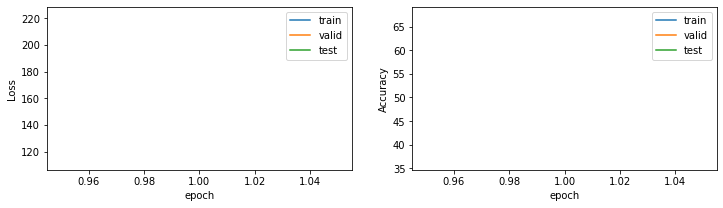

epoch: 1	batch Step: 0	Loss: 102.259	Accuracy: 60.000
epoch: 1	batch Step: 100	Loss: 147.768	Accuracy: 50.000
epoch: 1	batch Step: 200	Loss: 98.615	Accuracy: 60.000
epoch: 1	batch Step: 300	Loss: 80.956	Accuracy: 60.000
epoch: 1	batch Step: 400	Loss: 53.719	Accuracy: 90.000
epoch: 1	batch Step: 500	Loss: 48.161	Accuracy: 90.000
epoch: 1	batch Step: 600	Loss: 89.544	Accuracy: 60.000
epoch: 1	batch Step: 700	Loss: 72.336	Accuracy: 90.000
epoch: 1	batch Step: 800	Loss: 56.235	Accuracy: 80.000
epoch: 1	batch Step: 900	Loss: 107.610	Accuracy: 80.000
epoch: 1	batch Step: 1000	Loss: 101.908	Accuracy: 70.000
epoch: 1	batch Step: 1100	Loss: 64.002	Accuracy: 70.000
epoch: 1	batch Step: 1200	Loss: 108.990	Accuracy: 50.000
epoch: 1	batch Step: 1300	Loss: 56.749	Accuracy: 80.000
epoch: 1	batch Step: 1400	Loss: 102.790	Accuracy: 70.000
epoch: 1	batch Step: 1500	Loss: 127.551	Accuracy: 90.000
epoch: 1	batch Step: 1600	Loss: 73.672	Accuracy: 60.000
epoch: 1	batch Step: 1700	Loss: 132.379	Accuracy: 80.

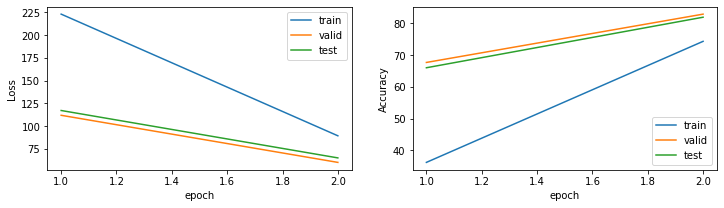

epoch: 2	batch Step: 0	Loss: 81.437	Accuracy: 70.000
epoch: 2	batch Step: 100	Loss: 95.464	Accuracy: 90.000
epoch: 2	batch Step: 200	Loss: 15.197	Accuracy: 100.000
epoch: 2	batch Step: 300	Loss: 28.469	Accuracy: 100.000
epoch: 2	batch Step: 400	Loss: 32.768	Accuracy: 90.000
epoch: 2	batch Step: 500	Loss: 31.958	Accuracy: 100.000
epoch: 2	batch Step: 600	Loss: 58.552	Accuracy: 70.000
epoch: 2	batch Step: 700	Loss: 13.221	Accuracy: 100.000
epoch: 2	batch Step: 800	Loss: 27.672	Accuracy: 100.000
epoch: 2	batch Step: 900	Loss: 72.995	Accuracy: 80.000
epoch: 2	batch Step: 1000	Loss: 84.385	Accuracy: 80.000
epoch: 2	batch Step: 1100	Loss: 61.860	Accuracy: 70.000
epoch: 2	batch Step: 1200	Loss: 47.728	Accuracy: 90.000
epoch: 2	batch Step: 1300	Loss: 46.452	Accuracy: 90.000
epoch: 2	batch Step: 1400	Loss: 87.712	Accuracy: 80.000
epoch: 2	batch Step: 1500	Loss: 84.573	Accuracy: 80.000
epoch: 2	batch Step: 1600	Loss: 41.066	Accuracy: 90.000
epoch: 2	batch Step: 1700	Loss: 76.160	Accuracy: 80.000

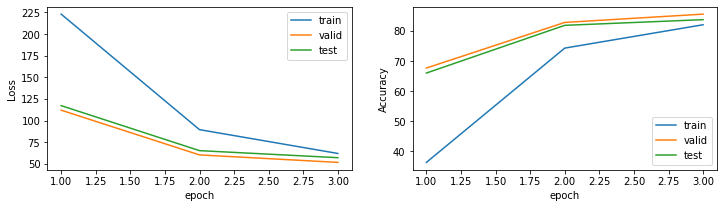

epoch: 3	batch Step: 0	Loss: 92.863	Accuracy: 70.000
epoch: 3	batch Step: 100	Loss: 65.041	Accuracy: 90.000
epoch: 3	batch Step: 200	Loss: 6.583	Accuracy: 100.000
epoch: 3	batch Step: 300	Loss: 35.802	Accuracy: 90.000
epoch: 3	batch Step: 400	Loss: 5.414	Accuracy: 100.000
epoch: 3	batch Step: 500	Loss: 8.600	Accuracy: 100.000
epoch: 3	batch Step: 600	Loss: 36.472	Accuracy: 80.000
epoch: 3	batch Step: 700	Loss: 11.796	Accuracy: 90.000
epoch: 3	batch Step: 800	Loss: 22.791	Accuracy: 90.000
epoch: 3	batch Step: 900	Loss: 77.280	Accuracy: 80.000
epoch: 3	batch Step: 1000	Loss: 78.479	Accuracy: 80.000
epoch: 3	batch Step: 1100	Loss: 66.540	Accuracy: 80.000
epoch: 3	batch Step: 1200	Loss: 24.601	Accuracy: 100.000
epoch: 3	batch Step: 1300	Loss: 48.211	Accuracy: 80.000
epoch: 3	batch Step: 1400	Loss: 105.387	Accuracy: 80.000
epoch: 3	batch Step: 1500	Loss: 35.228	Accuracy: 80.000
epoch: 3	batch Step: 1600	Loss: 23.529	Accuracy: 100.000
epoch: 3	batch Step: 1700	Loss: 56.484	Accuracy: 90.000
e

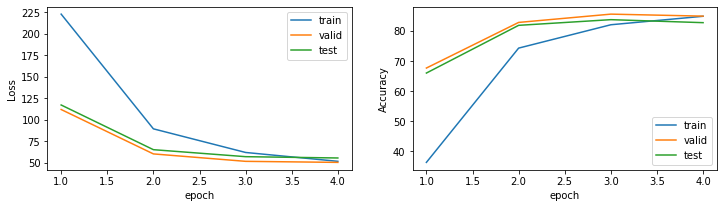

epoch: 4	batch Step: 0	Loss: 111.126	Accuracy: 70.000
epoch: 4	batch Step: 100	Loss: 91.409	Accuracy: 90.000
epoch: 4	batch Step: 200	Loss: 2.930	Accuracy: 100.000
epoch: 4	batch Step: 300	Loss: 36.102	Accuracy: 90.000
epoch: 4	batch Step: 400	Loss: 10.807	Accuracy: 100.000
epoch: 4	batch Step: 500	Loss: 15.139	Accuracy: 90.000
epoch: 4	batch Step: 600	Loss: 74.535	Accuracy: 70.000
epoch: 4	batch Step: 700	Loss: 10.240	Accuracy: 100.000
epoch: 4	batch Step: 800	Loss: 36.252	Accuracy: 90.000
epoch: 4	batch Step: 900	Loss: 51.048	Accuracy: 80.000
epoch: 4	batch Step: 1000	Loss: 49.990	Accuracy: 90.000
epoch: 4	batch Step: 1100	Loss: 21.686	Accuracy: 100.000
epoch: 4	batch Step: 1200	Loss: 22.017	Accuracy: 90.000
epoch: 4	batch Step: 1300	Loss: 20.327	Accuracy: 90.000
epoch: 4	batch Step: 1400	Loss: 50.632	Accuracy: 80.000
epoch: 4	batch Step: 1500	Loss: 33.847	Accuracy: 90.000
epoch: 4	batch Step: 1600	Loss: 35.048	Accuracy: 100.000
epoch: 4	batch Step: 1700	Loss: 59.628	Accuracy: 90.000

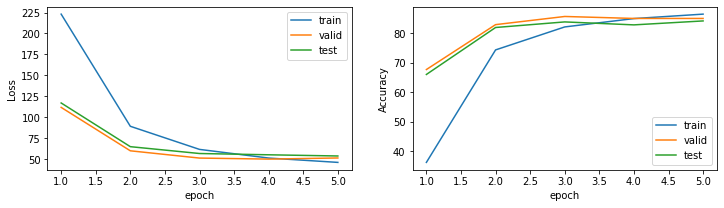

epoch: 5	batch Step: 0	Loss: 74.183	Accuracy: 80.000
epoch: 5	batch Step: 100	Loss: 101.482	Accuracy: 80.000
epoch: 5	batch Step: 200	Loss: 5.855	Accuracy: 100.000
epoch: 5	batch Step: 300	Loss: 45.105	Accuracy: 90.000
epoch: 5	batch Step: 400	Loss: 3.763	Accuracy: 100.000
epoch: 5	batch Step: 500	Loss: 9.453	Accuracy: 100.000
epoch: 5	batch Step: 600	Loss: 53.746	Accuracy: 80.000
epoch: 5	batch Step: 700	Loss: 2.041	Accuracy: 100.000
epoch: 5	batch Step: 800	Loss: 15.468	Accuracy: 90.000
epoch: 5	batch Step: 900	Loss: 38.230	Accuracy: 90.000
epoch: 5	batch Step: 1000	Loss: 40.126	Accuracy: 90.000
epoch: 5	batch Step: 1100	Loss: 19.634	Accuracy: 100.000
epoch: 5	batch Step: 1200	Loss: 22.696	Accuracy: 100.000
epoch: 5	batch Step: 1300	Loss: 27.205	Accuracy: 90.000
epoch: 5	batch Step: 1400	Loss: 78.007	Accuracy: 70.000
epoch: 5	batch Step: 1500	Loss: 16.638	Accuracy: 100.000
epoch: 5	batch Step: 1600	Loss: 39.684	Accuracy: 90.000
epoch: 5	batch Step: 1700	Loss: 81.619	Accuracy: 70.000


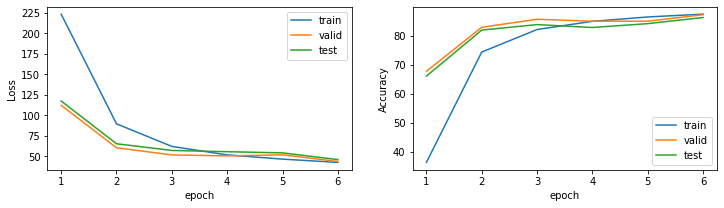

epoch: 6	batch Step: 0	Loss: 68.849	Accuracy: 70.000
epoch: 6	batch Step: 100	Loss: 84.155	Accuracy: 90.000
epoch: 6	batch Step: 200	Loss: 2.078	Accuracy: 100.000
epoch: 6	batch Step: 300	Loss: 35.221	Accuracy: 80.000
epoch: 6	batch Step: 400	Loss: 8.017	Accuracy: 100.000
epoch: 6	batch Step: 500	Loss: 5.878	Accuracy: 100.000
epoch: 6	batch Step: 600	Loss: 42.474	Accuracy: 80.000
epoch: 6	batch Step: 700	Loss: 3.332	Accuracy: 100.000
epoch: 6	batch Step: 800	Loss: 14.306	Accuracy: 100.000
epoch: 6	batch Step: 900	Loss: 36.886	Accuracy: 90.000
epoch: 6	batch Step: 1000	Loss: 37.833	Accuracy: 90.000
epoch: 6	batch Step: 1100	Loss: 23.164	Accuracy: 100.000
epoch: 6	batch Step: 1200	Loss: 41.746	Accuracy: 80.000
epoch: 6	batch Step: 1300	Loss: 16.874	Accuracy: 90.000
epoch: 6	batch Step: 1400	Loss: 64.316	Accuracy: 80.000
epoch: 6	batch Step: 1500	Loss: 32.534	Accuracy: 90.000
epoch: 6	batch Step: 1600	Loss: 37.965	Accuracy: 90.000
epoch: 6	batch Step: 1700	Loss: 62.009	Accuracy: 80.000
ep

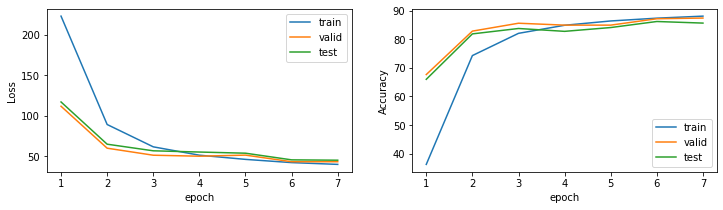

epoch: 7	batch Step: 0	Loss: 68.549	Accuracy: 70.000
epoch: 7	batch Step: 100	Loss: 117.113	Accuracy: 90.000
epoch: 7	batch Step: 200	Loss: 1.644	Accuracy: 100.000
epoch: 7	batch Step: 300	Loss: 31.050	Accuracy: 100.000
epoch: 7	batch Step: 400	Loss: 6.677	Accuracy: 100.000
epoch: 7	batch Step: 500	Loss: 4.347	Accuracy: 100.000
epoch: 7	batch Step: 600	Loss: 38.319	Accuracy: 90.000
epoch: 7	batch Step: 700	Loss: 9.417	Accuracy: 100.000
epoch: 7	batch Step: 800	Loss: 18.798	Accuracy: 90.000
epoch: 7	batch Step: 900	Loss: 27.458	Accuracy: 90.000
epoch: 7	batch Step: 1000	Loss: 48.128	Accuracy: 90.000
epoch: 7	batch Step: 1100	Loss: 26.410	Accuracy: 90.000
epoch: 7	batch Step: 1200	Loss: 15.011	Accuracy: 100.000
epoch: 7	batch Step: 1300	Loss: 18.825	Accuracy: 90.000
epoch: 7	batch Step: 1400	Loss: 84.364	Accuracy: 80.000
epoch: 7	batch Step: 1500	Loss: 32.999	Accuracy: 90.000
epoch: 7	batch Step: 1600	Loss: 22.204	Accuracy: 100.000
epoch: 7	batch Step: 1700	Loss: 53.860	Accuracy: 80.000


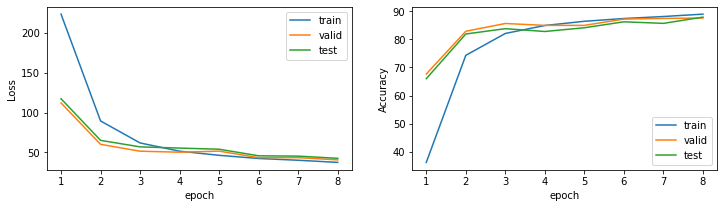

epoch: 8	batch Step: 0	Loss: 93.106	Accuracy: 70.000
epoch: 8	batch Step: 100	Loss: 95.596	Accuracy: 80.000
epoch: 8	batch Step: 200	Loss: 2.572	Accuracy: 100.000
epoch: 8	batch Step: 300	Loss: 31.954	Accuracy: 90.000
epoch: 8	batch Step: 400	Loss: 8.403	Accuracy: 100.000
epoch: 8	batch Step: 500	Loss: 22.960	Accuracy: 90.000
epoch: 8	batch Step: 600	Loss: 47.306	Accuracy: 80.000
epoch: 8	batch Step: 700	Loss: 1.221	Accuracy: 100.000
epoch: 8	batch Step: 800	Loss: 6.210	Accuracy: 100.000
epoch: 8	batch Step: 900	Loss: 25.566	Accuracy: 100.000
epoch: 8	batch Step: 1000	Loss: 41.332	Accuracy: 90.000
epoch: 8	batch Step: 1100	Loss: 30.044	Accuracy: 90.000
epoch: 8	batch Step: 1200	Loss: 20.748	Accuracy: 90.000
epoch: 8	batch Step: 1300	Loss: 27.807	Accuracy: 90.000
epoch: 8	batch Step: 1400	Loss: 100.755	Accuracy: 70.000
epoch: 8	batch Step: 1500	Loss: 10.472	Accuracy: 100.000
epoch: 8	batch Step: 1600	Loss: 43.228	Accuracy: 90.000
epoch: 8	batch Step: 1700	Loss: 65.348	Accuracy: 90.000
e

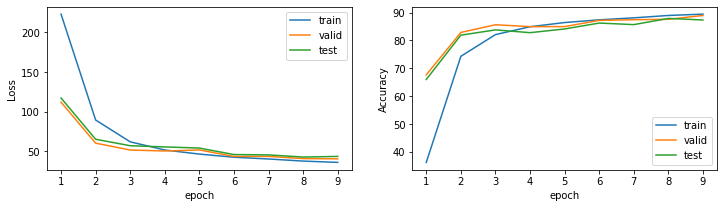

epoch: 9	batch Step: 0	Loss: 53.486	Accuracy: 80.000
epoch: 9	batch Step: 100	Loss: 89.569	Accuracy: 90.000
epoch: 9	batch Step: 200	Loss: 11.562	Accuracy: 100.000
epoch: 9	batch Step: 300	Loss: 25.150	Accuracy: 90.000
epoch: 9	batch Step: 400	Loss: 7.447	Accuracy: 100.000
epoch: 9	batch Step: 500	Loss: 5.491	Accuracy: 100.000
epoch: 9	batch Step: 600	Loss: 62.383	Accuracy: 60.000
epoch: 9	batch Step: 700	Loss: 8.044	Accuracy: 100.000
epoch: 9	batch Step: 800	Loss: 13.208	Accuracy: 100.000
epoch: 9	batch Step: 900	Loss: 22.063	Accuracy: 100.000
epoch: 9	batch Step: 1000	Loss: 54.950	Accuracy: 90.000
epoch: 9	batch Step: 1100	Loss: 29.085	Accuracy: 80.000
epoch: 9	batch Step: 1200	Loss: 23.808	Accuracy: 90.000
epoch: 9	batch Step: 1300	Loss: 17.253	Accuracy: 90.000
epoch: 9	batch Step: 1400	Loss: 84.980	Accuracy: 70.000
epoch: 9	batch Step: 1500	Loss: 4.868	Accuracy: 100.000
epoch: 9	batch Step: 1600	Loss: 49.358	Accuracy: 70.000
epoch: 9	batch Step: 1700	Loss: 57.434	Accuracy: 80.000
e

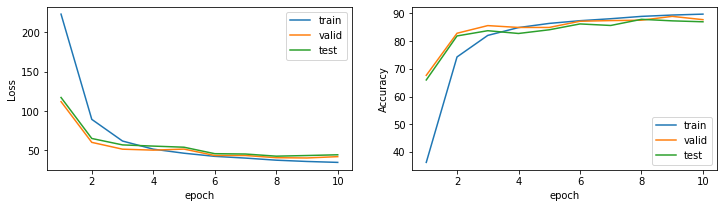

epoch: 10	batch Step: 0	Loss: 40.046	Accuracy: 90.000
epoch: 10	batch Step: 100	Loss: 86.288	Accuracy: 80.000
epoch: 10	batch Step: 200	Loss: 4.551	Accuracy: 100.000
epoch: 10	batch Step: 300	Loss: 13.415	Accuracy: 100.000
epoch: 10	batch Step: 400	Loss: 6.387	Accuracy: 100.000
epoch: 10	batch Step: 500	Loss: 11.178	Accuracy: 100.000
epoch: 10	batch Step: 600	Loss: 65.703	Accuracy: 80.000
epoch: 10	batch Step: 700	Loss: 1.324	Accuracy: 100.000
epoch: 10	batch Step: 800	Loss: 9.713	Accuracy: 100.000
epoch: 10	batch Step: 900	Loss: 24.788	Accuracy: 90.000
epoch: 10	batch Step: 1000	Loss: 37.568	Accuracy: 90.000
epoch: 10	batch Step: 1100	Loss: 18.181	Accuracy: 100.000
epoch: 10	batch Step: 1200	Loss: 10.796	Accuracy: 100.000
epoch: 10	batch Step: 1300	Loss: 27.008	Accuracy: 90.000
epoch: 10	batch Step: 1400	Loss: 83.513	Accuracy: 80.000
epoch: 10	batch Step: 1500	Loss: 17.466	Accuracy: 100.000
epoch: 10	batch Step: 1600	Loss: 56.238	Accuracy: 90.000
epoch: 10	batch Step: 1700	Loss: 70.95

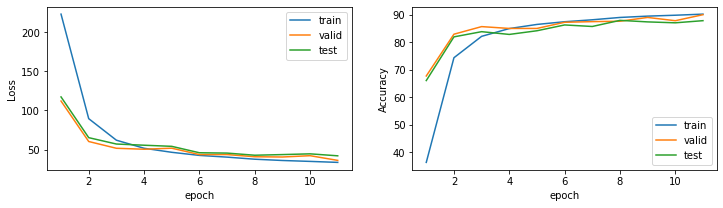

epoch: 11	batch Step: 0	Loss: 59.686	Accuracy: 80.000
epoch: 11	batch Step: 100	Loss: 101.567	Accuracy: 70.000
epoch: 11	batch Step: 200	Loss: 2.592	Accuracy: 100.000
epoch: 11	batch Step: 300	Loss: 22.162	Accuracy: 100.000
epoch: 11	batch Step: 400	Loss: 11.004	Accuracy: 100.000
epoch: 11	batch Step: 500	Loss: 3.758	Accuracy: 100.000
epoch: 11	batch Step: 600	Loss: 37.717	Accuracy: 80.000
epoch: 11	batch Step: 700	Loss: 3.456	Accuracy: 100.000
epoch: 11	batch Step: 800	Loss: 17.483	Accuracy: 90.000
epoch: 11	batch Step: 900	Loss: 17.792	Accuracy: 100.000
epoch: 11	batch Step: 1000	Loss: 19.769	Accuracy: 90.000
epoch: 11	batch Step: 1100	Loss: 9.563	Accuracy: 100.000
epoch: 11	batch Step: 1200	Loss: 29.562	Accuracy: 90.000
epoch: 11	batch Step: 1300	Loss: 45.395	Accuracy: 90.000
epoch: 11	batch Step: 1400	Loss: 58.885	Accuracy: 80.000
epoch: 11	batch Step: 1500	Loss: 28.181	Accuracy: 90.000
epoch: 11	batch Step: 1600	Loss: 32.422	Accuracy: 90.000
epoch: 11	batch Step: 1700	Loss: 22.678

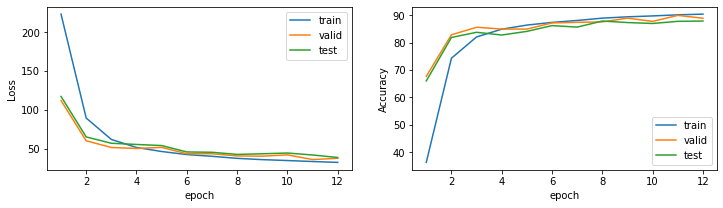

epoch: 12	batch Step: 0	Loss: 65.839	Accuracy: 70.000
epoch: 12	batch Step: 100	Loss: 41.353	Accuracy: 90.000
epoch: 12	batch Step: 200	Loss: 5.863	Accuracy: 100.000
epoch: 12	batch Step: 300	Loss: 13.386	Accuracy: 100.000
epoch: 12	batch Step: 400	Loss: 7.606	Accuracy: 100.000
epoch: 12	batch Step: 500	Loss: 3.773	Accuracy: 100.000
epoch: 12	batch Step: 600	Loss: 33.301	Accuracy: 80.000
epoch: 12	batch Step: 700	Loss: 0.915	Accuracy: 100.000
epoch: 12	batch Step: 800	Loss: 13.710	Accuracy: 90.000
epoch: 12	batch Step: 900	Loss: 28.181	Accuracy: 90.000
epoch: 12	batch Step: 1000	Loss: 33.753	Accuracy: 90.000
epoch: 12	batch Step: 1100	Loss: 16.226	Accuracy: 100.000
epoch: 12	batch Step: 1200	Loss: 39.777	Accuracy: 90.000
epoch: 12	batch Step: 1300	Loss: 20.600	Accuracy: 90.000
epoch: 12	batch Step: 1400	Loss: 67.777	Accuracy: 80.000
epoch: 12	batch Step: 1500	Loss: 12.395	Accuracy: 100.000
epoch: 12	batch Step: 1600	Loss: 28.958	Accuracy: 100.000
epoch: 12	batch Step: 1700	Loss: 37.196

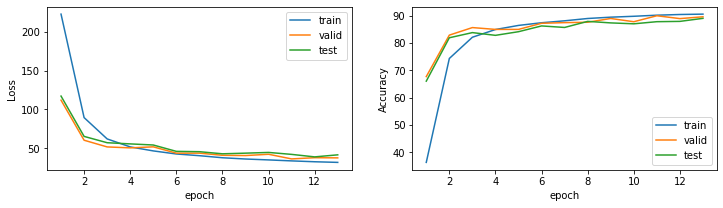

epoch: 13	batch Step: 0	Loss: 64.426	Accuracy: 70.000
epoch: 13	batch Step: 100	Loss: 53.353	Accuracy: 80.000
epoch: 13	batch Step: 200	Loss: 2.756	Accuracy: 100.000
epoch: 13	batch Step: 300	Loss: 9.111	Accuracy: 100.000
epoch: 13	batch Step: 400	Loss: 5.028	Accuracy: 100.000
epoch: 13	batch Step: 500	Loss: 4.016	Accuracy: 100.000
epoch: 13	batch Step: 600	Loss: 33.762	Accuracy: 90.000
epoch: 13	batch Step: 700	Loss: 7.511	Accuracy: 100.000
epoch: 13	batch Step: 800	Loss: 34.726	Accuracy: 80.000
epoch: 13	batch Step: 900	Loss: 18.893	Accuracy: 100.000
epoch: 13	batch Step: 1000	Loss: 44.121	Accuracy: 90.000
epoch: 13	batch Step: 1100	Loss: 10.960	Accuracy: 100.000
epoch: 13	batch Step: 1200	Loss: 53.531	Accuracy: 80.000
epoch: 13	batch Step: 1300	Loss: 58.167	Accuracy: 80.000
epoch: 13	batch Step: 1400	Loss: 98.858	Accuracy: 80.000
epoch: 13	batch Step: 1500	Loss: 22.523	Accuracy: 90.000
epoch: 13	batch Step: 1600	Loss: 31.966	Accuracy: 100.000
epoch: 13	batch Step: 1700	Loss: 36.120	

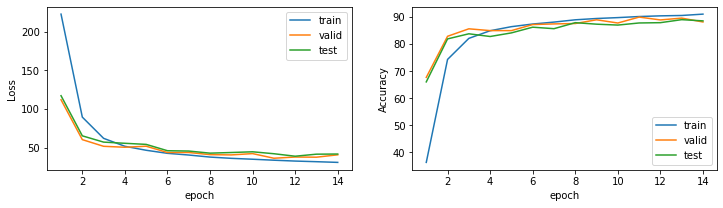

epoch: 14	batch Step: 0	Loss: 72.371	Accuracy: 70.000
epoch: 14	batch Step: 100	Loss: 67.594	Accuracy: 80.000
epoch: 14	batch Step: 200	Loss: 3.639	Accuracy: 100.000
epoch: 14	batch Step: 300	Loss: 38.325	Accuracy: 90.000
epoch: 14	batch Step: 400	Loss: 9.111	Accuracy: 100.000
epoch: 14	batch Step: 500	Loss: 9.525	Accuracy: 100.000
epoch: 14	batch Step: 600	Loss: 39.723	Accuracy: 80.000
epoch: 14	batch Step: 700	Loss: 0.849	Accuracy: 100.000
epoch: 14	batch Step: 800	Loss: 6.247	Accuracy: 100.000
epoch: 14	batch Step: 900	Loss: 26.692	Accuracy: 100.000
epoch: 14	batch Step: 1000	Loss: 19.650	Accuracy: 90.000
epoch: 14	batch Step: 1100	Loss: 9.504	Accuracy: 100.000
epoch: 14	batch Step: 1200	Loss: 48.526	Accuracy: 80.000
epoch: 14	batch Step: 1300	Loss: 31.331	Accuracy: 90.000
epoch: 14	batch Step: 1400	Loss: 61.513	Accuracy: 80.000
epoch: 14	batch Step: 1500	Loss: 17.355	Accuracy: 100.000
epoch: 14	batch Step: 1600	Loss: 44.360	Accuracy: 90.000
epoch: 14	batch Step: 1700	Loss: 15.541	A

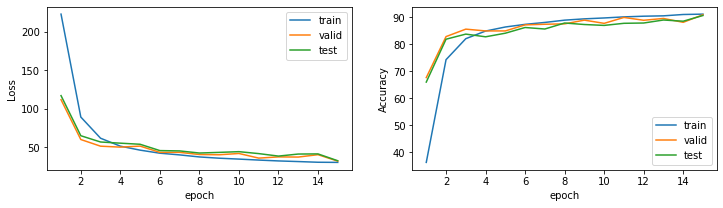

epoch: 15	batch Step: 0	Loss: 40.896	Accuracy: 80.000
epoch: 15	batch Step: 100	Loss: 97.455	Accuracy: 70.000
epoch: 15	batch Step: 200	Loss: 2.854	Accuracy: 100.000
epoch: 15	batch Step: 300	Loss: 18.470	Accuracy: 100.000
epoch: 15	batch Step: 400	Loss: 11.476	Accuracy: 90.000
epoch: 15	batch Step: 500	Loss: 4.280	Accuracy: 100.000
epoch: 15	batch Step: 600	Loss: 32.030	Accuracy: 80.000
epoch: 15	batch Step: 700	Loss: 2.522	Accuracy: 100.000
epoch: 15	batch Step: 800	Loss: 3.525	Accuracy: 100.000
epoch: 15	batch Step: 900	Loss: 23.006	Accuracy: 90.000
epoch: 15	batch Step: 1000	Loss: 32.887	Accuracy: 90.000
epoch: 15	batch Step: 1100	Loss: 15.058	Accuracy: 100.000
epoch: 15	batch Step: 1200	Loss: 29.186	Accuracy: 90.000
epoch: 15	batch Step: 1300	Loss: 10.608	Accuracy: 100.000
epoch: 15	batch Step: 1400	Loss: 78.702	Accuracy: 70.000
epoch: 15	batch Step: 1500	Loss: 19.595	Accuracy: 100.000
epoch: 15	batch Step: 1600	Loss: 64.261	Accuracy: 80.000
epoch: 15	batch Step: 1700	Loss: 31.621

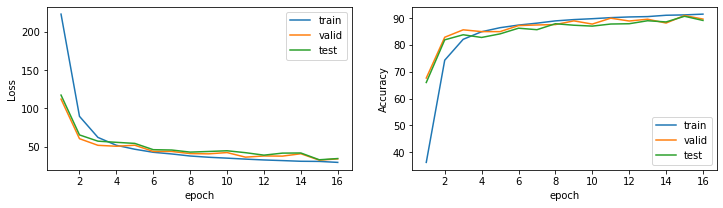

epoch: 16	batch Step: 0	Loss: 50.433	Accuracy: 90.000
epoch: 16	batch Step: 100	Loss: 47.365	Accuracy: 90.000
epoch: 16	batch Step: 200	Loss: 17.071	Accuracy: 90.000
epoch: 16	batch Step: 300	Loss: 20.252	Accuracy: 90.000
epoch: 16	batch Step: 400	Loss: 2.251	Accuracy: 100.000
epoch: 16	batch Step: 500	Loss: 2.925	Accuracy: 100.000
epoch: 16	batch Step: 600	Loss: 53.031	Accuracy: 70.000
epoch: 16	batch Step: 700	Loss: 1.288	Accuracy: 100.000
epoch: 16	batch Step: 800	Loss: 2.588	Accuracy: 100.000
epoch: 16	batch Step: 900	Loss: 14.525	Accuracy: 100.000
epoch: 16	batch Step: 1000	Loss: 42.248	Accuracy: 90.000
epoch: 16	batch Step: 1100	Loss: 11.718	Accuracy: 100.000
epoch: 16	batch Step: 1200	Loss: 40.604	Accuracy: 90.000
epoch: 16	batch Step: 1300	Loss: 12.729	Accuracy: 90.000
epoch: 16	batch Step: 1400	Loss: 95.497	Accuracy: 70.000
epoch: 16	batch Step: 1500	Loss: 35.234	Accuracy: 90.000
epoch: 16	batch Step: 1600	Loss: 26.474	Accuracy: 90.000
epoch: 16	batch Step: 1700	Loss: 35.946	A

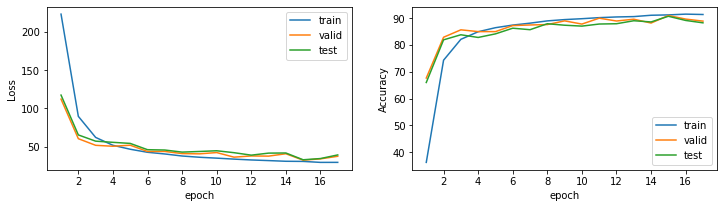

epoch: 17	batch Step: 0	Loss: 55.512	Accuracy: 80.000
epoch: 17	batch Step: 100	Loss: 85.089	Accuracy: 80.000
epoch: 17	batch Step: 200	Loss: 3.970	Accuracy: 100.000
epoch: 17	batch Step: 300	Loss: 8.909	Accuracy: 100.000
epoch: 17	batch Step: 400	Loss: 3.822	Accuracy: 100.000
epoch: 17	batch Step: 500	Loss: 10.176	Accuracy: 100.000
epoch: 17	batch Step: 600	Loss: 42.927	Accuracy: 80.000
epoch: 17	batch Step: 700	Loss: 1.902	Accuracy: 100.000
epoch: 17	batch Step: 800	Loss: 6.346	Accuracy: 100.000
epoch: 17	batch Step: 900	Loss: 32.673	Accuracy: 90.000
epoch: 17	batch Step: 1000	Loss: 18.116	Accuracy: 90.000
epoch: 17	batch Step: 1100	Loss: 11.289	Accuracy: 100.000
epoch: 17	batch Step: 1200	Loss: 23.229	Accuracy: 90.000
epoch: 17	batch Step: 1300	Loss: 17.625	Accuracy: 90.000
epoch: 17	batch Step: 1400	Loss: 30.216	Accuracy: 90.000
epoch: 17	batch Step: 1500	Loss: 12.302	Accuracy: 100.000
epoch: 17	batch Step: 1600	Loss: 37.647	Accuracy: 80.000
epoch: 17	batch Step: 1700	Loss: 19.406	

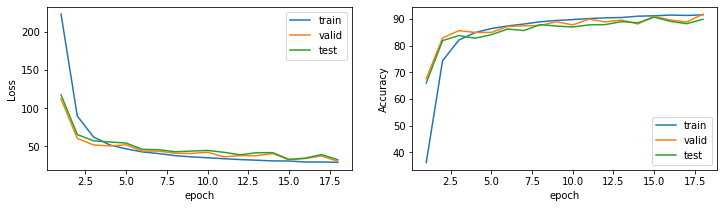

epoch: 18	batch Step: 0	Loss: 47.065	Accuracy: 90.000
epoch: 18	batch Step: 100	Loss: 28.752	Accuracy: 90.000
epoch: 18	batch Step: 200	Loss: 1.686	Accuracy: 100.000
epoch: 18	batch Step: 300	Loss: 7.074	Accuracy: 100.000
epoch: 18	batch Step: 400	Loss: 6.735	Accuracy: 100.000
epoch: 18	batch Step: 500	Loss: 8.709	Accuracy: 100.000
epoch: 18	batch Step: 600	Loss: 52.936	Accuracy: 80.000
epoch: 18	batch Step: 700	Loss: 1.270	Accuracy: 100.000
epoch: 18	batch Step: 800	Loss: 4.265	Accuracy: 100.000
epoch: 18	batch Step: 900	Loss: 12.530	Accuracy: 100.000
epoch: 18	batch Step: 1000	Loss: 39.072	Accuracy: 90.000
epoch: 18	batch Step: 1100	Loss: 18.863	Accuracy: 100.000
epoch: 18	batch Step: 1200	Loss: 53.634	Accuracy: 80.000
epoch: 18	batch Step: 1300	Loss: 32.352	Accuracy: 80.000
epoch: 18	batch Step: 1400	Loss: 37.870	Accuracy: 80.000
epoch: 18	batch Step: 1500	Loss: 5.409	Accuracy: 100.000
epoch: 18	batch Step: 1600	Loss: 32.392	Accuracy: 90.000
epoch: 18	batch Step: 1700	Loss: 21.663	A

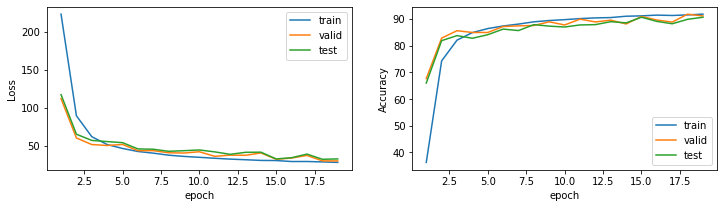

epoch: 19	batch Step: 0	Loss: 49.755	Accuracy: 90.000
epoch: 19	batch Step: 100	Loss: 37.774	Accuracy: 90.000
epoch: 19	batch Step: 200	Loss: 4.170	Accuracy: 100.000
epoch: 19	batch Step: 300	Loss: 10.742	Accuracy: 100.000
epoch: 19	batch Step: 400	Loss: 5.264	Accuracy: 100.000
epoch: 19	batch Step: 500	Loss: 14.534	Accuracy: 90.000
epoch: 19	batch Step: 600	Loss: 43.982	Accuracy: 80.000
epoch: 19	batch Step: 700	Loss: 1.211	Accuracy: 100.000
epoch: 19	batch Step: 800	Loss: 5.398	Accuracy: 100.000
epoch: 19	batch Step: 900	Loss: 23.398	Accuracy: 100.000
epoch: 19	batch Step: 1000	Loss: 20.395	Accuracy: 90.000
epoch: 19	batch Step: 1100	Loss: 8.830	Accuracy: 100.000
epoch: 19	batch Step: 1200	Loss: 41.206	Accuracy: 80.000
epoch: 19	batch Step: 1300	Loss: 5.741	Accuracy: 100.000
epoch: 19	batch Step: 1400	Loss: 52.576	Accuracy: 90.000
epoch: 19	batch Step: 1500	Loss: 9.536	Accuracy: 100.000
epoch: 19	batch Step: 1600	Loss: 36.995	Accuracy: 80.000
epoch: 19	batch Step: 1700	Loss: 29.026	A

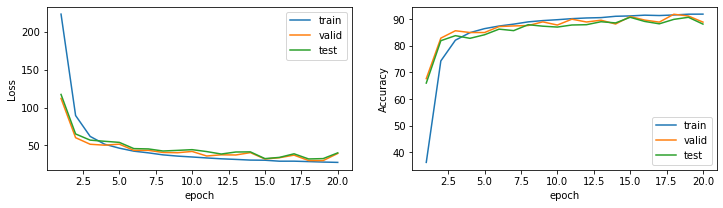

epoch: 20	batch Step: 0	Loss: 33.581	Accuracy: 80.000
epoch: 20	batch Step: 100	Loss: 35.311	Accuracy: 90.000
epoch: 20	batch Step: 200	Loss: 1.330	Accuracy: 100.000
epoch: 20	batch Step: 300	Loss: 15.162	Accuracy: 90.000
epoch: 20	batch Step: 400	Loss: 3.105	Accuracy: 100.000
epoch: 20	batch Step: 500	Loss: 6.907	Accuracy: 100.000
epoch: 20	batch Step: 600	Loss: 32.234	Accuracy: 80.000
epoch: 20	batch Step: 700	Loss: 1.146	Accuracy: 100.000
epoch: 20	batch Step: 800	Loss: 2.470	Accuracy: 100.000
epoch: 20	batch Step: 900	Loss: 24.959	Accuracy: 90.000
epoch: 20	batch Step: 1000	Loss: 6.002	Accuracy: 100.000
epoch: 20	batch Step: 1100	Loss: 9.665	Accuracy: 100.000
epoch: 20	batch Step: 1200	Loss: 56.817	Accuracy: 80.000
epoch: 20	batch Step: 1300	Loss: 42.221	Accuracy: 80.000
epoch: 20	batch Step: 1400	Loss: 34.858	Accuracy: 90.000
epoch: 20	batch Step: 1500	Loss: 21.753	Accuracy: 90.000
epoch: 20	batch Step: 1600	Loss: 23.472	Accuracy: 90.000
epoch: 20	batch Step: 1700	Loss: 29.178	Acc

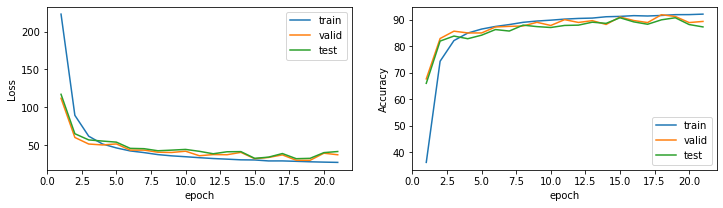

epoch: 21	batch Step: 0	Loss: 67.412	Accuracy: 70.000
epoch: 21	batch Step: 100	Loss: 24.294	Accuracy: 90.000
epoch: 21	batch Step: 200	Loss: 15.115	Accuracy: 100.000
epoch: 21	batch Step: 300	Loss: 7.880	Accuracy: 100.000
epoch: 21	batch Step: 400	Loss: 4.673	Accuracy: 100.000
epoch: 21	batch Step: 500	Loss: 1.695	Accuracy: 100.000
epoch: 21	batch Step: 600	Loss: 51.049	Accuracy: 70.000
epoch: 21	batch Step: 700	Loss: 2.152	Accuracy: 100.000
epoch: 21	batch Step: 800	Loss: 6.983	Accuracy: 100.000
epoch: 21	batch Step: 900	Loss: 30.532	Accuracy: 80.000
epoch: 21	batch Step: 1000	Loss: 43.368	Accuracy: 90.000
epoch: 21	batch Step: 1100	Loss: 25.033	Accuracy: 100.000
epoch: 21	batch Step: 1200	Loss: 80.041	Accuracy: 80.000
epoch: 21	batch Step: 1300	Loss: 4.048	Accuracy: 100.000
epoch: 21	batch Step: 1400	Loss: 71.759	Accuracy: 70.000
epoch: 21	batch Step: 1500	Loss: 19.194	Accuracy: 90.000
epoch: 21	batch Step: 1600	Loss: 29.919	Accuracy: 90.000
epoch: 21	batch Step: 1700	Loss: 36.015	A

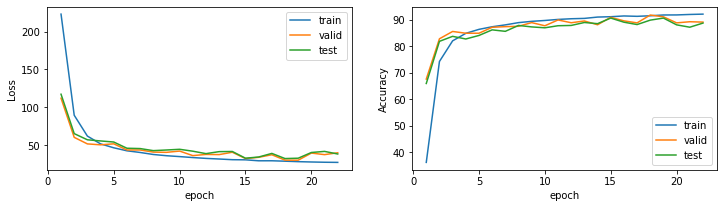

epoch: 22	batch Step: 0	Loss: 30.100	Accuracy: 90.000
epoch: 22	batch Step: 100	Loss: 55.317	Accuracy: 70.000
epoch: 22	batch Step: 200	Loss: 2.376	Accuracy: 100.000
epoch: 22	batch Step: 300	Loss: 7.753	Accuracy: 100.000
epoch: 22	batch Step: 400	Loss: 4.651	Accuracy: 100.000
epoch: 22	batch Step: 500	Loss: 6.735	Accuracy: 100.000
epoch: 22	batch Step: 600	Loss: 49.766	Accuracy: 80.000
epoch: 22	batch Step: 700	Loss: 1.446	Accuracy: 100.000
epoch: 22	batch Step: 800	Loss: 3.172	Accuracy: 100.000
epoch: 22	batch Step: 900	Loss: 19.074	Accuracy: 100.000
epoch: 22	batch Step: 1000	Loss: 20.816	Accuracy: 90.000
epoch: 22	batch Step: 1100	Loss: 16.843	Accuracy: 100.000
epoch: 22	batch Step: 1200	Loss: 62.737	Accuracy: 80.000
epoch: 22	batch Step: 1300	Loss: 18.508	Accuracy: 90.000
epoch: 22	batch Step: 1400	Loss: 41.043	Accuracy: 90.000
epoch: 22	batch Step: 1500	Loss: 23.404	Accuracy: 90.000
epoch: 22	batch Step: 1600	Loss: 32.173	Accuracy: 90.000
epoch: 22	batch Step: 1700	Loss: 39.749	A

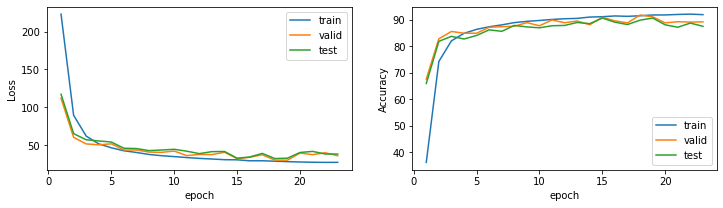

epoch: 23	batch Step: 0	Loss: 36.871	Accuracy: 80.000
epoch: 23	batch Step: 100	Loss: 30.169	Accuracy: 90.000
epoch: 23	batch Step: 200	Loss: 5.672	Accuracy: 100.000
epoch: 23	batch Step: 300	Loss: 3.808	Accuracy: 100.000
epoch: 23	batch Step: 400	Loss: 4.098	Accuracy: 100.000
epoch: 23	batch Step: 500	Loss: 11.089	Accuracy: 90.000
epoch: 23	batch Step: 600	Loss: 29.717	Accuracy: 70.000
epoch: 23	batch Step: 700	Loss: 7.899	Accuracy: 100.000
epoch: 23	batch Step: 800	Loss: 10.176	Accuracy: 90.000
epoch: 23	batch Step: 900	Loss: 24.393	Accuracy: 90.000
epoch: 23	batch Step: 1000	Loss: 24.992	Accuracy: 100.000
epoch: 23	batch Step: 1100	Loss: 28.487	Accuracy: 80.000
epoch: 23	batch Step: 1200	Loss: 34.953	Accuracy: 70.000
epoch: 23	batch Step: 1300	Loss: 12.447	Accuracy: 100.000
epoch: 23	batch Step: 1400	Loss: 49.328	Accuracy: 90.000
epoch: 23	batch Step: 1500	Loss: 13.690	Accuracy: 100.000
epoch: 23	batch Step: 1600	Loss: 56.863	Accuracy: 80.000
epoch: 23	batch Step: 1700	Loss: 37.026	

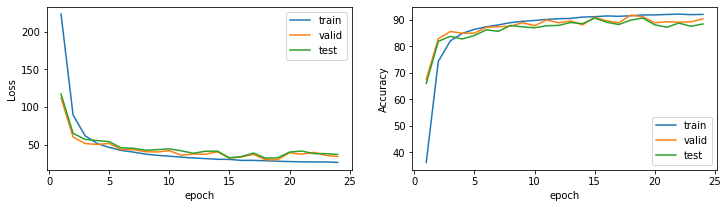

epoch: 24	batch Step: 0	Loss: 58.229	Accuracy: 80.000
epoch: 24	batch Step: 100	Loss: 43.970	Accuracy: 90.000
epoch: 24	batch Step: 200	Loss: 2.201	Accuracy: 100.000
epoch: 24	batch Step: 300	Loss: 7.309	Accuracy: 100.000
epoch: 24	batch Step: 400	Loss: 1.268	Accuracy: 100.000
epoch: 24	batch Step: 500	Loss: 6.379	Accuracy: 100.000
epoch: 24	batch Step: 600	Loss: 38.797	Accuracy: 80.000
epoch: 24	batch Step: 700	Loss: 1.725	Accuracy: 100.000
epoch: 24	batch Step: 800	Loss: 10.719	Accuracy: 90.000
epoch: 24	batch Step: 900	Loss: 18.620	Accuracy: 100.000
epoch: 24	batch Step: 1000	Loss: 12.988	Accuracy: 90.000
epoch: 24	batch Step: 1100	Loss: 34.257	Accuracy: 80.000
epoch: 24	batch Step: 1200	Loss: 36.813	Accuracy: 90.000
epoch: 24	batch Step: 1300	Loss: 10.231	Accuracy: 90.000
epoch: 24	batch Step: 1400	Loss: 53.497	Accuracy: 80.000
epoch: 24	batch Step: 1500	Loss: 17.448	Accuracy: 90.000
epoch: 24	batch Step: 1600	Loss: 19.682	Accuracy: 100.000
epoch: 24	batch Step: 1700	Loss: 13.014	A

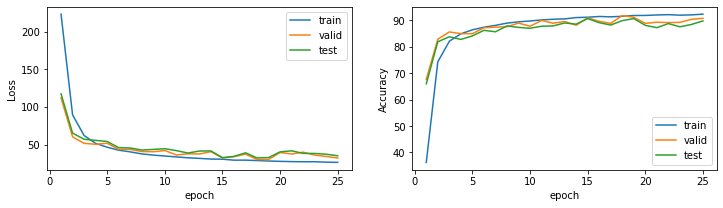

In [ ]:
# 통일성 있게 코드 짜자.
train_epoch_loss = []
train_epoch_acc = []
valid_epoch_loss = []
valid_epoch_acc = []
test_epoch_loss = []
test_epoch_acc = []

batch_size = 10

for epoch in range(epochs):

    ''' Train '''
    model.train()
    train_batch_loss = []
    train_batch_acc = []
   
    
    train_batch_num = int(len(X_train)/batch_size)
    # print("train_batch_num: ", train_batch_num)
    for batch_idx in range(train_batch_num):
        
        mini_batch_x = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size] # (50, 173, 24)
        mini_batch_x = mini_batch_x.unsqueeze(1) # (50, 1, 173, 24)
        mini_batch_y = Y_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
        x, target = Variable(mini_batch_x).to(device), Variable(mini_batch_y.long()).to(device)

        optimizer.zero_grad()
        output = model(x) # output.shape = (50, 30)
        target = target.squeeze(1)  # (50, 1, 30) -> (50, 30)
        target = torch.argmax(target, dim=1) # -> (50) 

        loss = F.nll_loss(output, target).to(device)
        
        loss.backward()    # calc gradients
        train_batch_loss.append(loss.item()*100) # ★ /batch_size F.nll_loss 가 mean 값을 보내니깐!
        optimizer.step()   # update gradients
        prediction = output.argmax(dim=1, keepdims=True)
        accuracy = torch.true_divide(prediction.eq(target.view_as(prediction)).sum().data, batch_size)*100
        train_batch_acc.append(accuracy.item())
        if batch_idx % print_interval == 0:
            print('epoch: {}\tbatch Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(
                    epoch, batch_idx, train_batch_loss[batch_idx], train_batch_acc[batch_idx]))

    train_epoch_loss.append(np.sum(train_batch_loss)/train_batch_num)
    train_epoch_acc.append(np.sum(train_batch_acc)/train_batch_num)

    ''' Valid '''
    model.eval()
    valid_batch_loss = []
    valid_batch_acc = []
    
    valid_batch_num = int(len(X_valid)/batch_size)
    # print("train_batch_num: ", valid_batch_num)
    with torch.no_grad():
        for batch_idx in range(valid_batch_num):         
            mini_batch_x = X_valid[batch_idx*batch_size:(batch_idx+1)*batch_size] # (50, 173, 24)
            mini_batch_x = mini_batch_x.unsqueeze(1) # (50, 1, 173, 24)
            mini_batch_y = Y_valid[batch_idx*batch_size:(batch_idx+1)*batch_size]
            x, target = Variable(mini_batch_x).to(device), Variable(mini_batch_y.long()).to(device)

            optimizer.zero_grad()
            output = model(x) # output.shape = (50, 30)
            target = target.squeeze(1)  # (50, 1, 30) -> (50, 30)
            target = torch.argmax(target, dim=1) # -> (50) 
            x, target = Variable(x).to(device), Variable(target).to(device)
            output = model(x)
            loss = F.nll_loss(output, target).to(device)

            valid_batch_loss.append(loss.item()*100)  #★/batch_size
            prediction = output.argmax(dim=1, keepdims=True)
            accuracy = torch.true_divide(prediction.eq(target.view_as(prediction)).sum().data, batch_size)*100
            valid_batch_acc.append(accuracy.item())

    valid_epoch_loss.append(np.sum(valid_batch_loss)/valid_batch_num)
    valid_epoch_acc.append(np.sum(valid_batch_acc)/valid_batch_num)


    ''' Test '''
    model.eval()
    test_batch_loss = []
    test_batch_acc = []
    
    test_batch_num = int(len(X_test)/batch_size)
    # print("train_batch_num: ", test_batch_num)
    with torch.no_grad():
        for batch_idx in range(test_batch_num):         
            mini_batch_x = X_test[batch_idx*batch_size:(batch_idx+1)*batch_size] # (50, 173, 24)
            mini_batch_x = mini_batch_x.unsqueeze(1) # (50, 1, 173, 24)
            mini_batch_y = Y_test[batch_idx*batch_size:(batch_idx+1)*batch_size]
            x, target = Variable(mini_batch_x).to(device), Variable(mini_batch_y.long()).to(device)

            optimizer.zero_grad()
            output = model(x) # output.shape = (50, 30)
            target = target.squeeze(1)  # (50, 1, 30) -> (50, 30)
            target = torch.argmax(target, dim=1) # -> (50) 
            x, target = Variable(x).to(device), Variable(target).to(device)
            output = model(x)
            loss = F.nll_loss(output, target).to(device)

            test_batch_loss.append(loss.item()*100)  #★/batch_size
            prediction = output.argmax(dim=1, keepdims=True)
            accuracy = torch.true_divide(prediction.eq(target.view_as(prediction)).sum().data, batch_size)*100
            test_batch_acc.append(accuracy.item())

    test_epoch_loss.append(np.sum(test_batch_loss)/test_batch_num)
    test_epoch_acc.append(np.sum(test_batch_acc)/test_batch_num)

    ############### 중간 plot & 모델 저장
    x_axis = np.arange(start=1, stop=len(train_epoch_loss)+1, step=1)

    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(1, 2, 1)
    plt.plot(x_axis, train_epoch_loss, label='train')
    plt.plot(x_axis, valid_epoch_loss, label='valid')
    plt.plot(x_axis, test_epoch_loss, label='test')
    ax1.legend()
    ax1.set(ylabel="Loss", xlabel='epoch')

    ax2 = fig.add_subplot(1, 2, 2)
    plt.plot(x_axis, train_epoch_acc, label='train')
    plt.plot(x_axis, valid_epoch_acc, label='valid')
    plt.plot(x_axis, test_epoch_acc, label='test')
    ax2.legend()
    ax2.set(ylabel="Accuracy", xlabel='epoch')

    plt.show()

    # ''' inference를 위한 모델 저장  '''
    model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
    model_name = "./ResNet_cv"
    option = 2

    if option == 0:
        model_path = model_name + '_all.pt'
        torch.save(model, model_path)

    elif option == 1:
        model_path = model_name + '_state_dict.pt'
        torch.save(model.state_dict, model_path)

    elif option == 2:
        model_path = model_name + '_ckp.tar'
        torch.save({
                'last_epoch': epochs -1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, model_path)
    ################ 중간 plot & 모델 저장

# Train 끝
test_final_acc = "train_{:.3f}_test_{:.3f}".format(train_epoch_acc[-1],
                                           test_epoch_acc[-1])
experience_path = "./실험_cv/" + test_final_acc
os.makedirs(experience_path, exist_ok=True)
train_test_result = (train_epoch_loss, valid_epoch_loss,test_epoch_loss, 
                     train_epoch_acc, test_epoch_acc, valid_epoch_acc)
np.save(experience_path+"/result.npy", train_test_result)

f = open(experience_path+"/train_spec.txt", 'w')
drop_prob1 = 0
f.write("epoch:{}, lr:{}, drop_prob1:{}, drop_prob2:{}, weight_decay={}\n".format(
    epochs, lr, drop_prob1, drop_prob2, weight_decay
))
f.write("Accuracy\n=====================\n")
f.write("Train:{:.3f}, Valid:{:.3f}, Test:{:.3f}".format(
        train_epoch_acc[-1], valid_epoch_acc[-1], test_epoch_acc[-1]))
f.close()

    

In [ ]:
print(test_epoch_acc[-1].item())

89.66667175292969


In [ ]:
test_final_acc = "train_{:.3f}_test_{:.3f}".format(train_epoch_acc[-1].item(),
                                           test_epoch_acc[-1].item())
experience_path = "./실험_cv/" + test_final_acc
os.makedirs(experience_path, exist_ok=True)
train_test_result = (train_epoch_loss, valid_epoch_loss,test_epoch_loss, 
                     train_epoch_acc, test_epoch_acc, valid_epoch_acc)
np.save(experience_path+"/result.npy", train_test_result)

f = open(experience_path+"/train_spec.txt", 'w')
drop_prob1 = 0
f.write("epoch:{}, lr:{}, drop_prob1:{}, drop_prob2:{}, weight_decay={}\n".format(
    epochs, lr, drop_prob1, drop_prob2, weight_decay
))
f.write("Accuracy\n=====================\n")
f.write("Train:{:.3f}, Valid:{:.3f}, Test:{:.3f}".format(
        train_epoch_acc[-1].item(), valid_epoch_acc[-1].item(), test_epoch_acc[-1].item()))
f.close()

## Confusion Matrix

In [ ]:
pip install seaborn

In [ ]:
import seaborn as sns
import pandas as pd

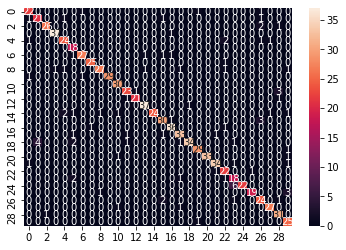

In [ ]:
classes = ['bed', 'bird', 'cat', 'dog', 'down', 
           'eight', 'five', 'four', 'go', 'happy', 
           'house', 'left', 'marvin', 'nine', 'no', 
           'off', 'on', 'one', 'right', 'seven', 
           'sheila', 'six', 'stop', 'three', 'tree', 
           'two', 'up', 'wow', 'yes', 'zero']
nb_classes = len(classes)
confusion_matrix = np.zeros((nb_classes, nb_classes))

with torch.no_grad():
    for idx in range(len(X_test)):
        inputs = X_test[idx:idx+1]
        target =Y_test[idx:idx+1]
        inputs = inputs.unsqueeze(1).to(device)
        target = target.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs)

        t = torch.argmax(Y_test[idx:idx+1])
        p = preds.item()
        #print("target:{}, predict{}".format(t, p))

        confusion_matrix[t, p] += 1

sns.heatmap(confusion_matrix, annot=True) 

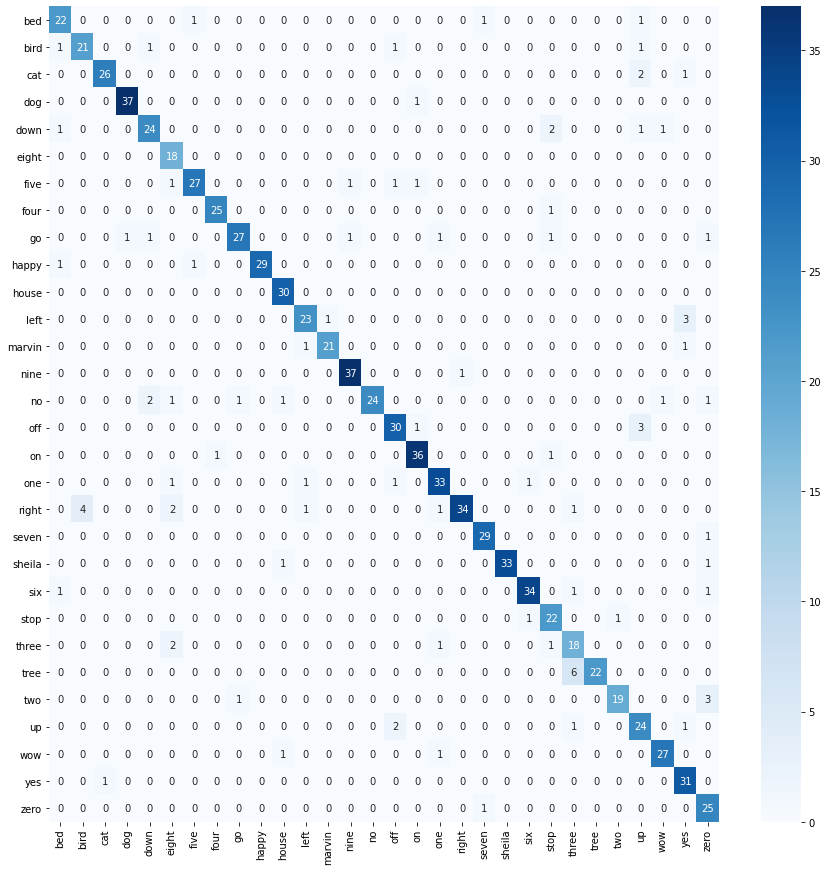

In [ ]:
M = pd.DataFrame(confusion_matrix)
M.columns = classes
M.index = classes
#print(M)

plt.figure(figsize=(15,15))
sns.heatmap(M, cmap='Blues',annot=True) 

## audio test
https://musicinformationretrieval.com/ipython_audio.html

In [ ]:
import IPython.display as ipd
import librosa

def match_1s(data):
    # 30sec 길이 통일
    num = 22050
    # print(data.shape, end=' ->')
    if len(data) < 22050:
        num = 22050 - len(data)
        temp = np.zeros(num) #* 1e-05
        data = np.append(data, temp)
    elif len(data) > 22050:
        data = data[:22050]

    #print(data.shape, end=' ')

    # (22050,) to column vector : (2250, 1)
    # data = data.reshape(len(data), 1)

    return data


def feature_mfcc(RECORD_FILE_NAME):

    # 조정할 수 있는 건 다 적어보자.

    # sr = 22050 = bitrate/2 -> Q. bitrate 와 어떤 관계?
    # Generate mfccs from a time series
    # t초당 sig.shape = (t*sr,)
    sig, sr = librosa.load(RECORD_FILE_NAME)  # , sr=sr
    # 만약, sr=16000, mfcc.shape = (n_mfcc,1251)
    #       sr=(default)22050, mfcc.shape = (n_mfcc, 1723)


    hop_length = 0
    if len(sig) == 22050:  # 128 -> mfcc Tx 301, 223 -> mfcc Tx 173
        hop_length = 128
    elif len(sig) == 38433:
        hop_length = 223  # Tx 173 으로 통일
    elif len(sig) < 22050:
        # print("smaller than", end=' ')
        sig = match_1s(sig)
        hop_length = 128

    else:
        # print(len(sig))
        sig = match_1s(sig)
        print("1s over")
        hop_length = 128

    n_mfcc = 24
    # n_mels = 20
    n_fft = 101
    fmin = 0
    fmax = None
    # sr = 16000


    mfcc = librosa.feature.mfcc(y=sig, sr=sr, hop_length=hop_length, fmin=fmin, fmax = fmax,
                                  n_fft= n_fft, n_mfcc=n_mfcc)
    # print("here", mfcc.shape)

    return mfcc

In [ ]:
audio_path = './dev_word/stop.wav' # 'stop_not_mine.wav' # 'extraction.wav'
ipd.Audio(audio_path)

In [ ]:
mfcc = feature_mfcc(audio_path)
print(mfcc.shape)

1s over
(24, 173)


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:284: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


In [ ]:
''' 모델 불러오기 '''

model_save_type = ["all", "state_dict", "ckp"]  # 학습 재개를 위해서 ckp 저장 권장 // else state_dict
model_name = "./ResNet_cv"
option = 2

if option == 0:
    # 모델 클래스는 어딘가에 반드시 선언되어 있어야 합니다
    model_path = model_name + '_all.pt'
    model = torch.load(model_path)

elif option == 1:
    model_path = model_name + '_state_dict.pt'
    model = CNN_Net().to(device)
    model.load_state_dict(torch.load(model_path))

elif option == 2:
    # model, optimizer 초기화
    #model = CNN_Net().to(device)
    #optimizer = optim.Adam(model.parameters(), lr=lr)

    model_path = model_name + '_ckp.tar'
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['last_epoch']
    loss = checkpoint['loss']


''' Audio Test '''

classes = ['bed', 'bird', 'cat', 'dog', 'down', 
           'eight', 'five', 'four', 'go', 'happy', 
           'house', 'left', 'marvin', 'nine', 'no', 
           'off', 'on', 'one', 'right', 'seven', 
           'sheila', 'six', 'stop', 'three', 'tree', 
           'two', 'up', 'wow', 'yes', 'zero']

model.eval()

with torch.no_grad():
    # mfcc.shape = (24, 173) -> (batch_szie=1, channel=1, 173, 24)
    mfcc = mfcc.transpose()
    print(mfcc.shape) ##
    x = np.expand_dims(mfcc, axis=(0, 1))
    x = Variable(torch.Tensor(x)).to(device)
    #print(x.shape) ##
    output = model(x) # output.shape = (1, 30)
    print(output.shape) ##
    output = torch.exp(output).float()
    for i in range(num_class):
        print(classes[i], ":", output[0][i].cpu())
    prediction = output.argmax(dim=1, keepdims=True)
    print("prediction : ", classes[prediction])


model.eval()
model.cuda()
test_batch_num = int(len(X_test)/batch_size)
# print("train_batch_num: ", test_batch_num)
with torch.no_grad():
    for batch_idx in range(test_batch_num):         
        mini_batch_x = X_test[batch_idx*batch_size:(batch_idx+1)*batch_size] # (50, 173, 24)
        mini_batch_x = mini_batch_x.unsqueeze(1) # (50, 1, 173, 24)
        mini_batch_y = Y_test[batch_idx*batch_size:(batch_idx+1)*batch_size]
        x, target = Variable(mini_batch_x).to(device), Variable(mini_batch_y.long()).to(device)

    output = model(x) # output.shape = (1, 30)
    prediction = output.argmax(dim=1, keepdims=True)
    for b in range(batch_size):
        print("target :", classes[target[b].argmax(dim=1).item()], " || prediction :", classes[prediction[b]])


(173, 24)
torch.Size([1, 30])
bed : tensor(1.9693e-07)
bird : tensor(5.1202e-07)
cat : tensor(8.6277e-08)
dog : tensor(0.0004)
down : tensor(1.2718e-05)
eight : tensor(3.7938e-06)
five : tensor(0.0001)
four : tensor(9.7751e-06)
go : tensor(2.3734e-07)
happy : tensor(1.0031e-06)
house : tensor(3.6598e-06)
left : tensor(6.8344e-07)
marvin : tensor(1.1017e-08)
nine : tensor(3.7292e-07)
no : tensor(3.1640e-07)
off : tensor(2.2956e-05)
on : tensor(7.3092e-07)
one : tensor(8.3028e-09)
right : tensor(1.7574e-08)
seven : tensor(8.5344e-06)
sheila : tensor(5.2236e-07)
six : tensor(1.9389e-05)
stop : tensor(0.9969)
three : tensor(2.5283e-05)
tree : tensor(5.2270e-08)
two : tensor(2.3871e-07)
up : tensor(0.0024)
wow : tensor(9.6918e-06)
yes : tensor(1.1071e-06)
zero : tensor(3.7291e-06)
prediction :  stop
target : go  || prediction : go
target : yes  || prediction : yes
target : sheila  || prediction : sheila
target : tree  || prediction : tree
target : bed  || prediction : up
target : wow  || pr